### Utility function

In [1]:
import matplotlib.pyplot as plt


def display(img, size=2):
    plt.figure(figsize=(size, size))
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.show()

### Data preprocessing

In [2]:
import torch
from torch.utils.data import Dataset, random_split
from mnist import MNIST


class MnistDataset(Dataset):
    def __init__(self, train: bool):
        self.train = train
        mndata = MNIST("./data")

        self.images, self.labels = None, None

        if train:
            self.images, self.labels = mndata.load_training()
        else:
            self.images, self.labels = mndata.load_testing()

        self.labels = torch.tensor(self.labels, dtype=torch.uint8)
        self.images = torch.tensor(self.images, dtype=torch.float32)

        self.images = self.images / torch.max(self.images)
        self.images = torch.reshape(self.images, (-1, 28, 28))
        self.images = torch.unsqueeze(self.images, 1)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [3]:
dataset_train_val = MnistDataset(train=True)
dataset_test = MnistDataset(train=False)

dataset_train, dataset_val = random_split(dataset_train_val, [54000, 6000])

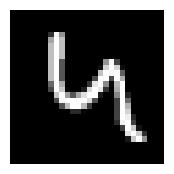

In [4]:
display(dataset_train[0][0][0])

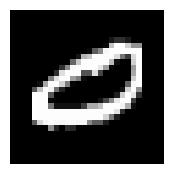

In [5]:
display(dataset_train[42][0][0])

In [6]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset_train, batch_size=60, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=10, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=100, shuffle=True)

### Build NN

In [7]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [8]:
from torch import nn
import torch.optim as optim


class MnistClassifier(nn.Module):
    def __init__(self, conv1_layers: int = 32, conv2_layers=64):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(1, conv1_layers, 5),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(conv1_layers, conv2_layers, 3),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(conv2_layers * 5 * 5, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
            nn.LogSoftmax(dim=0),
        )

        self.loss = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(self.parameters(), lr=0.001, momentum=0.1)

    def forward(self, x):
        logits = self.seq(x)
        return logits

    def optimize_paramters(self, inputs, labels):
        # zero the parameter gradients
        self.optimizer.zero_grad()

        # forward + backward + optimize
        outputs = self(inputs)
        loss = self.loss(outputs, labels)
        loss.backward()
        self.optimizer.step()

        return loss

### Training

In [9]:
import time


net = MnistClassifier()

start_time = time.time()

for epoch in range(3):  # loop over the dataset multiple times
    print(f"Epoch: {epoch}")
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        loss = net.optimize_paramters(inputs, labels)

        # Gather data and report
        running_loss += loss.item()

    print(
        f"[{epoch + 1}] training loss: {running_loss / (len(train_dataloader) * train_dataloader.batch_size):.5f}"
    )
    running_loss = 0.0

    with torch.no_grad():
        val_loss = 0
        for i, data in enumerate(val_dataloader, 0):
            inputs, labels = data
            outputs = net(inputs)
            loss = net.loss(outputs, labels)

            val_loss += loss.item()

        print(
            f"[{epoch + 1}] validation loss: {val_loss / (len(val_dataloader) * val_dataloader.batch_size):.5f}"
        )
        val_loss = 0.0

end_time = time.time()

print(f"Finished Training in {end_time - start_time:.1f}s")

Epoch: 0
[1] training loss: 0.03755
[1] validation loss: 0.02186
Epoch: 1
[2] training loss: 0.03350
[2] validation loss: 0.01703
Epoch: 2
[3] training loss: 0.02118
[3] validation loss: 0.00906
Finished Training in 46.9s


In [10]:
correct_pred = {classname: 0 for classname in map(str, range(10))}
total_pred = {classname: 0 for classname in map(str, range(10))}

with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = net(images)
        predictions = torch.argmax(outputs, dim=1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[str(label.item())] += 1
            total_pred[str(label.item())] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f"Accuracy for class: {classname:5s} is {accuracy:.1f} %")

Accuracy for class: 0     is 81.7 %
Accuracy for class: 1     is 93.1 %
Accuracy for class: 2     is 61.6 %
Accuracy for class: 3     is 67.2 %
Accuracy for class: 4     is 69.0 %
Accuracy for class: 5     is 53.4 %
Accuracy for class: 6     is 75.8 %
Accuracy for class: 7     is 74.9 %
Accuracy for class: 8     is 52.6 %
Accuracy for class: 9     is 57.7 %


tensor([3, 0, 1, 2, 1, 7, 6, 4, 1, 5])
tensor([5, 0, 1, 2, 1, 9, 6, 4, 1, 6], dtype=torch.uint8)


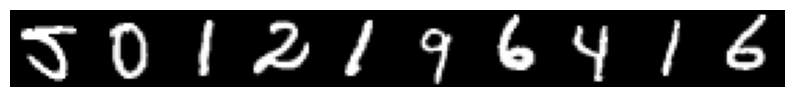

tensor([0, 4, 2, 0, 3, 7, 5, 4, 3, 1])
tensor([0, 4, 2, 0, 3, 7, 5, 4, 3, 1], dtype=torch.uint8)


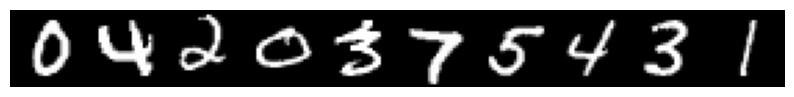

tensor([4, 1, 8, 0, 6, 9, 2, 7, 5, 4])
tensor([7, 1, 8, 8, 6, 7, 2, 7, 5, 9], dtype=torch.uint8)


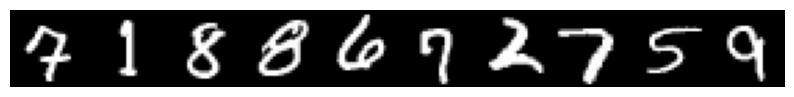

tensor([0, 2, 4, 9, 1, 3, 7, 8, 6, 3])
tensor([0, 8, 9, 7, 9, 5, 7, 8, 6, 7], dtype=torch.uint8)


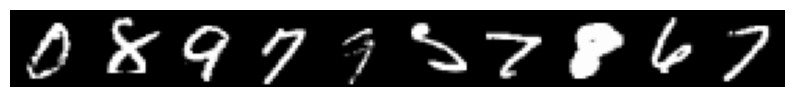

tensor([1, 2, 0, 0, 8, 7, 4, 3, 4, 6])
tensor([1, 2, 5, 6, 8, 7, 4, 3, 6, 6], dtype=torch.uint8)


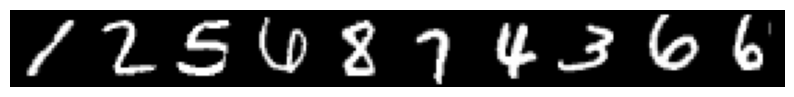

tensor([1, 3, 6, 4, 7, 2, 1, 1, 4, 0])
tensor([1, 3, 6, 8, 2, 2, 1, 8, 4, 0], dtype=torch.uint8)


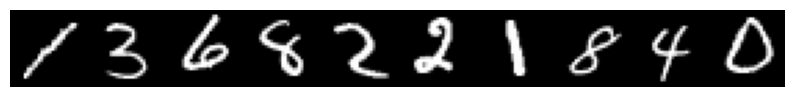

tensor([9, 8, 1, 9, 6, 4, 6, 2, 7, 1])
tensor([9, 8, 8, 4, 6, 4, 6, 2, 7, 4], dtype=torch.uint8)


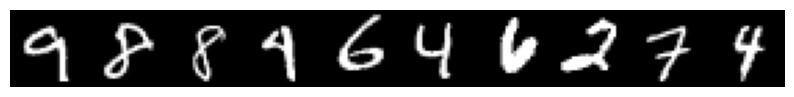

tensor([4, 9, 9, 5, 3, 8, 0, 6, 1, 7])
tensor([4, 4, 9, 5, 8, 8, 7, 6, 1, 7], dtype=torch.uint8)


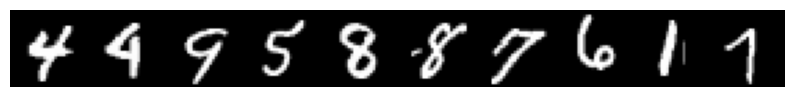

In [11]:
import numpy as np


def result():
    dataiter = iter(test_dataloader)

    image_to_display = None

    for _ in range(8):
        images, labels = next(dataiter)
        output = net(images)
        print(torch.argmax(output, dim=1))
        print(labels)

        images = torch.squeeze(images, dim=1).numpy()

        image_to_display = images[0]

        for i in range(1, len(images)):
            image_to_display = np.hstack((image_to_display, images[i]))

        display(image_to_display, size=10)


with torch.no_grad():
    result()